In [1]:
import pandas as pd
import numpy as np
import qgrid
from plotnine import *
from mizani import *
import warnings
warnings.filterwarnings('ignore')

def extract_max(x):
    res = str(x).split(' - ')
    if res[0]=='-': return np.nan
    return float(res[0]) if len(res)==1 else float(res[1])

In [2]:
dpt = pd.read_csv('data/IN_CSV_DPT_31012020.CSV', sep='|')
dpt.head()

,Bank,Saving,Fixed 3 mths,Fixed 6 mths,Fixed 12 mths,Fixed 24 mths
0,Bangkok Bank,0.5000 - 0.6250,1.0000,1.2500,1.3750 - 1.5000,1.5000
1,Krung Thai Bank,0.5000,0.9000,1.1500 - 1.3500,1.3000,1.4500
2,Kasikornbank,0.5000,0.6500 - 0.9000,0.9000 - 1.1500,1.0500 - 1.3000,1.2000 - 1.4500
3,The Siam Commercial Bank,0.5000,0.6500 - 0.9000,0.9000 - 1.1500,1.1500 - 1.4000,1.2000 - 1.4500
4,Bank of Ayudhya,0.3000,0.6500 - 0.9000,0.9000 - 1.2000,1.1500 - 1.4000,1.2000 - 1.5000


In [3]:
dpt['max_saving'] = dpt.Saving.map(extract_max)
dpt['max_24'] = dpt['Fixed 24 mths'].map(extract_max)
dpt = dpt[['Bank','max_saving','max_24']]
print(dpt.shape)
dpt.tail()

(33, 3)


,Bank,max_saving,max_24
28,RHB Bank Berhad,1.10,NaN
29,Oversea Chinese Banking Corporation,0.35,NaN
30,Mizuho Bank,0.40,NaN
31,BNP Paribas,NaN,NaN
32,Min - Max of Foreign Bank Branches,1.10,2.0


In [4]:
lne = pd.read_csv('data/IN_CSV_LNE_31012020.CSV', sep='|')
lne.head()

,Bank,MOR,MLR,MRR,Ceiling,Default,Credit Card
0,Bangkok Bank,6.8750,6.000,6.8750,18.00,21.8750,18.0000
1,Krung Thai Bank,6.8700,6.025,6.8700,17.12,19.8750,-
2,Kasikornbank,6.8700,6.000,6.8700,23.10,25.1000,18.0000
3,The Siam Commercial Bank,6.7450,6.025,6.8700,28.00,28.0000,18.0000
4,Bank of Ayudhya,6.9500,6.350,6.9500,21.00,28.0000,-


In [5]:
lne = lne[['Bank','MRR','MLR']]
lne['MRR'] = lne.MRR.map(extract_max)
lne['MLR'] = lne.MLR.map(extract_max)
print(lne.shape)
lne.head()

(33, 3)


,Bank,MRR,MLR
0,Bangkok Bank,6.875,6.000
1,Krung Thai Bank,6.870,6.025
2,Kasikornbank,6.870,6.000
3,The Siam Commercial Bank,6.870,6.025
4,Bank of Ayudhya,6.950,6.350


In [6]:
df = dpt.merge(lne,on='Bank')
df.shape

(31, 5)

In [7]:
df['diff_rich'] = df['MLR'] - df['max_24']
df['diff_therest'] = df['MRR'] - df['max_saving']
df.head()

,Bank,max_saving,max_24,MRR,MLR,diff_rich,diff_therest
0,Bangkok Bank,0.625,1.50,6.875,6.000,4.500,6.25
1,Krung Thai Bank,0.500,1.45,6.870,6.025,4.575,6.37
2,Kasikornbank,0.500,1.45,6.870,6.000,4.550,6.37
3,The Siam Commercial Bank,0.500,1.45,6.870,6.025,4.575,6.37
4,Bank of Ayudhya,0.300,1.50,6.950,6.350,4.850,6.65


In [8]:
qgrid.show_grid(df[['Bank','diff_rich','diff_therest']])

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

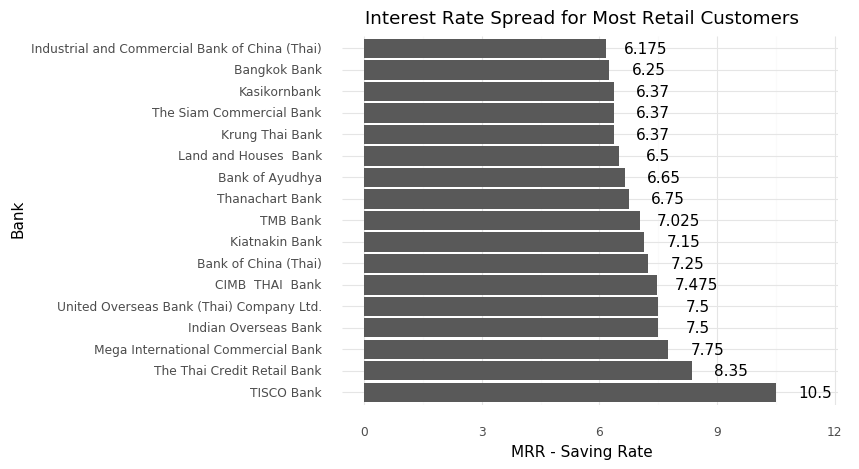

<ggplot: (-9223363300289416956)>

In [9]:
therest_df = df.copy()
therest_df = therest_df.sort_values('diff_therest',ascending=False).dropna()
therest_df['Bank'] = pd.Categorical(therest_df['Bank'],categories=therest_df.Bank)
g = (ggplot(therest_df, aes(x='Bank',y='diff_therest')) + geom_col() + coord_flip() +
    theme_minimal() + geom_text(aes(x='Bank',y='diff_therest+1',label='round(diff_therest,3)'))+
    xlab('Bank') + ylab('MRR - Saving Rate') + ggtitle('Interest Rate Spread for Most Retail Customers'))
g

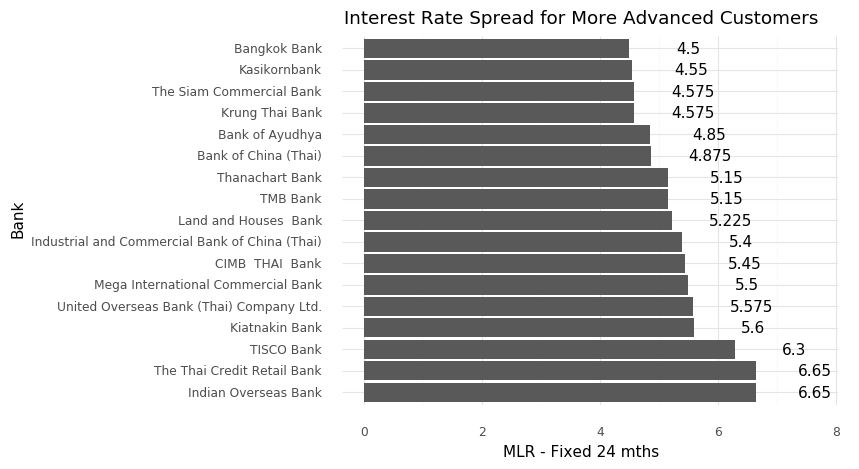

<ggplot: (8736561432275)>

In [10]:
rich_df = df.copy()
rich_df = rich_df.sort_values('diff_rich',ascending=False).dropna()
rich_df['Bank'] = pd.Categorical(rich_df['Bank'],categories=rich_df.Bank)
g = (ggplot(rich_df, aes(x='Bank',y='diff_rich')) + geom_col() + coord_flip() +
    theme_minimal() + geom_text(aes(x='Bank',y='diff_rich+1',label='round(diff_rich,3)'))+
    xlab('Bank') + ylab('MLR - Fixed 24 mths') + ggtitle('Interest Rate Spread for More Advanced Customers'))
g

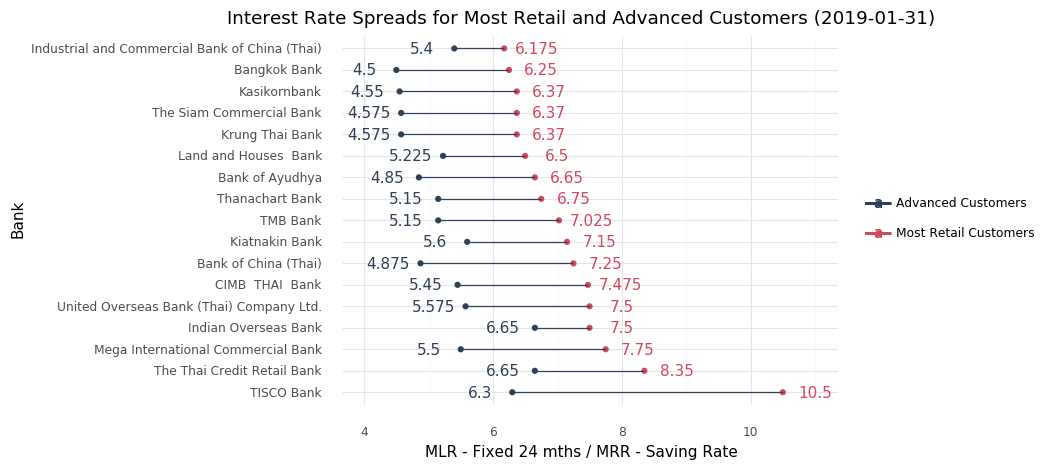

<ggplot: (-9223363300300132373)>

In [49]:
both_df = df[['Bank','diff_rich','diff_therest']]
both_df = both_df.sort_values('diff_therest',ascending=False).dropna()
both_df['Bank'] = pd.Categorical(both_df['Bank'],categories=both_df.Bank)
both_df = both_df.melt(id_vars='Bank')
g = (ggplot(both_df, aes(x='Bank',y='value',color='variable',group='Bank')) + geom_point() + 
     geom_line() + theme_minimal() + coord_flip() +
     scale_color_manual(labels = ['Advanced Customers','Most Retail Customers'], values=('#2e4057','#d1495b')) +
     geom_text(both_df[both_df.variable=='diff_therest'], aes(x='Bank',y='value+0.5',label='round(value,3)')) +
     geom_text(both_df[both_df.variable=='diff_rich'], aes(x='Bank',y='value-0.5',label='round(value,3)')) +
     theme(legend_title=element_blank()) +
     xlab('Bank') + ylab('MLR - Fixed 24 mths / MRR - Saving Rate') + 
     ggtitle('Interest Rate Spreads for Most Retail and Advanced Customers (2019-01-31)'))
g